# Techniques of High Performance Computing - Assignment 4

**Name: John Duffy**

**Student Number: 19154676**

# In the Moment of Heat

Reference: The SIAM 100-Digit Challenge: A Study in High-Accuracy Numerical Computing, Folkmar Bourneman et al

## Program Description

Order
Stability - Courant Number <= 1/4.
Precision

## Programming for Precision

General considerations...

Addition and multiplication good

Subtraction and division bad

Make numbers bigger before making them smaller

Maximise integer operations

Minimise floating point operations

Do floating point operations after integer operations


## Program Structure

The plate domain of [-1, 1] x [-1, 1] is translated to [0, 2] x [0, 2] for easier manipulation of array indexes and reduce computing complexity and time.

To investigate... a number of methods... using common paramter names as follows

* u(x, y) - an (x, y) position on the plate.

* N - the number of space grid points, and is common to the X and Y axis.

* M - the number of time points.

* h - the distance between space grid points, (N - 1) / 2.

* k - the distance between time points, (M - 1) / 2.

* C - the Courant number, k / h^2.

* T - The time the centre of the plate reaches 1.0

M and N are selected to be odd numbers to ensure an even number of space and time intervals, and so that the temperature of the centre of the plate is easily accessed as the array index, u[(N - 1) / 2, (N - 1) / 2].

### Methods

float64

The maximum positive integer value that can be stored in a int64 is:

    9_223_372_036_854_775_808

We want to use the maximum possible integer without generating an integer overflow, so the following values were used:

    0 -> 1_000_000_000_000_000_000
    1 -> 1_100_000_000_000_000_000
    5 -> 1_500_000_000_000_000_000
    
Initially, to keep the notebook running time below 2 minutes, the following values were used.

    0 -> 1_000_000_000_000
    1 -> 1_100_000_000_000
    5 -> 1_500_000_000_000

#### Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_NUMBA_FLOAT64


#### Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64


#### Central Differences in Space and Forward Euler in Time - CD_SPACE_FE_TIME_ARRAY_SLICES_INT64


#### Central Differences in Space and Forward Euler in Time - CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64


#### Central Differences in Space and Forward Euler in Time - CD_SPACE_RK4_TIME_ARRAY_SLICES_INT64


#### Central Differences in Space and Forward Euler in Time - CD_SPACE_RK4_TIME_OPENCL_INT64




## Performance and Optimisation

### Baseline Performance

To measure the relative performance of each method standard values of M, N were used as follows:

* M: 201

* N: 40001
    
Resulting in the following values of h, k and C:

* h: 0.01

* k: 0.000025

* C: 0.25

Because the Central Differences method used to determine u'(t) is second order accurate in h, with the above choice of parameters it should be possible to achieve an accuracy of 0.0001 in T.

The baseline results for each method are presented below:

    CD_SPACE_FE_TIME_NUMBA_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 19.993767976760864

    CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 4.624581813812256
    
    CD_SPACE_FE_TIME_ARRAY_SLICES_INT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 4.513350009918213

    CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240250000000000
    Total time: 18.09891104698181
    
    CD_SPACE_RK4_TIME_ARRAY_SLICES_INT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240250000000000
    Total time: 19.447755098342896

    CD_SPACE_FE_TIME_OPENCL_INT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240000000000000
    Total time: 11.867632150650024

    CD_SPACE_RK4_TIME_OPENCL_INT64
    N: 201
    M: 40001
    C: 0.25
    T: 0.4240250000000000
    Total time: 26.951719045639038
    
As can been seen is the results above, all 6 methods are accurate to 4 decimal places as expected.

For the CD_SPACE_FE_TIME methods the ARRAY_SLICES method is significantly faster than the NUMBA method. This is probably due to Numba been able to parallelise array slicing very efficiently, and also the reduced function call overhead. Because of this increased speed, the ARRAY_SLICES method was selected to see how much further precision can be gained with a reduced space and time intervals.

As should be expected, the RK4 methods take longer due to the increased processing required.

### Increased Precision

    CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
    N: 501
    M: 250001
    C: 0.25
    T: 0.4240080000000000
    Total time: 196.95271515846252
    
    CD_SPACE_FE_TIME_ARRAY_SLICES_INT64
    N: 501
    M: 250001
    C: 0.25
    T: 0.4240080000000000
    Total time: 189.750324010849
    
    CD_SPACE_FE_TIME_OPENCL_INT64
    N: 501
    M: 250001
    C: 0.25
    T: 0.4240000000000000
    Total time: 202.91219091415405
    
    CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
    N: 501
    M: 500001
    C: 0.125
    T: 0.4240100000000000
    Total time: 353.85502219200134
    
    CD_SPACE_FE_TIME_OPENCL_INT64
    N: 501
    M: 500001
    C: 0.125
    T: 0.4240080000000000
    Total time: 405.8607587814331

    
    

In [13]:
# Import required libraries...

import pyopencl as cl
import numpy as np
import time

from numba import njit, prange

In [14]:
# declare a utility array plotting function...

import matplotlib.pyplot as plt

def plot(u):
    plt.figure(figsize=(8, 6))
    plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Reds')
    plt.colorbar()
    plt.show()

In [15]:
# Declare a useful timer class...

class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [16]:
# Integer values for arbitary precision methods...

# Initial values to keep notebook runtime less than 2 minutes...

INT_BIG_0 = 1_000_000_000_000
INT_BIG_1 = 1_100_000_000_000
INT_BIG_5 = 1_500_000_000_000

### CD_SPACE_FE_TIME_NUMBA_FLOAT64

In [17]:
@njit(parallel=True)
def step(n, m, u):
    '''
    This function
    '''
    v = np.copy(u)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            v[row, col] = u[row, col] - (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1]) * (n - 1) * (n - 1) / (4 * (m - 1))

    return v

CD_SPACE_FE_TIME_NUMBA_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 21.221549034118652


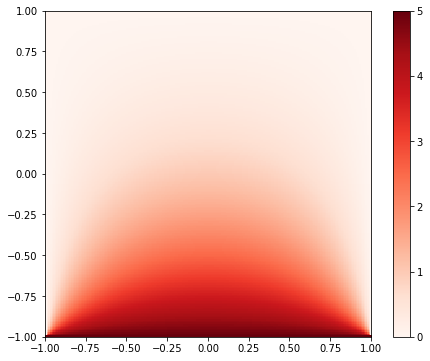

In [18]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_NUMBA_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = step(N, M, u)
        i = i + 1
    
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64

CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 5.179279804229736


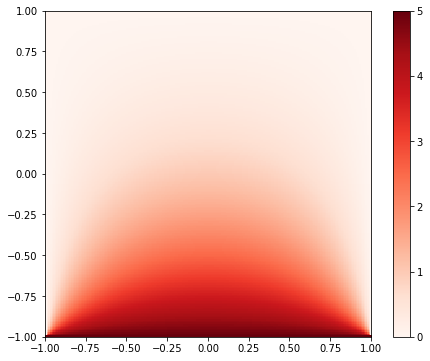

In [19]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_ARRAY_SLICES_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] + (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (N - 1) * (N - 1) / (4 * (M - 1))
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_ARRAY_SLICES_INT64

CD_SPACE_FE_TIME_ARRAY_SLICES_INT64
N: 201
M: 40001
C: 0.25
T: 0.4240000000000000
Total time: 5.104498863220215


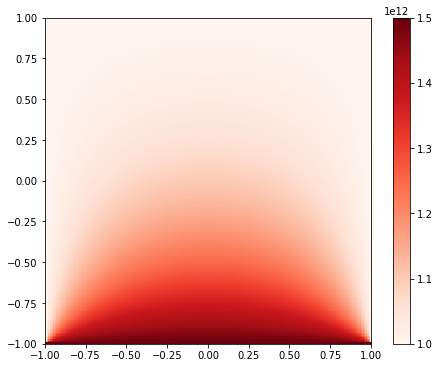

In [20]:
N = 201
M = 40001

print("CD_SPACE_FE_TIME_ARRAY_SLICES_INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), INT_BIG_0, dtype=np.int64)

u[0, :] = INT_BIG_5

i = 0

with Timer() as t:    
    while u[(N - 1) // 2, (N - 1) // 2] < INT_BIG_1:
        u[1:N-1, 1:N-1] = u[1:N-1, 1:N-1] + (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (N - 1) * (N - 1) / (4 * (M - 1))
        i = i + 1
    
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64

In [21]:
@njit
def f(n, m, u, v):
    v[1:N-1, 1:N-1] = (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (n - 1) * (n - 1) / (4 * (m - 1))

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    f(n, m, u, k1)
    f(n, m, u + k1 / 2, k2)
    f(n, m, u + k2 / 2, k3)
    f(n, m, u + k3, k4)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64
N: 201
M: 40001
C: 0.25
T: 0.4240250000000000
Total time: 19.471980094909668


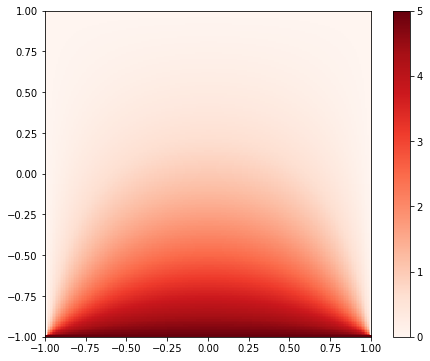

In [22]:
N = 201
M = 40001

print("CD_SPACE_RK4_TIME_ARRAY_SLICES_FLOAT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.zeros((N, N), dtype=np.float64)

u[0, :] = 5.0

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_RK4_TIME_ARRAY_SLICES_INT64

In [23]:
@njit
def f(n, m, u, v):
    v[1:N-1, 1:N-1] = (u[0:N-2, 1:N-1] + u[2:N, 1:N-1] + u[1:N-1, 0:N-2] + u[1:N-1, 2:N] - 4 * u[1:N-1, 1:N-1]) * (n - 1) * (n - 1) / (4 * (m - 1))

@njit
def rk4_func(n, m, u):

    k1 = np.zeros((n, n), dtype=u.dtype)
    k2 = np.zeros((n, n), dtype=u.dtype)
    k3 = np.zeros((n, n), dtype=u.dtype)
    k4 = np.zeros((n, n), dtype=u.dtype)
    
    f(n, m, u, k1)
    f(n, m, u + k1 / 2, k2)
    f(n, m, u + k2 / 2, k3)
    f(n, m, u + k3, k4)
    
    return u + (k1 + 2 * k2 + 2 * k3 + k4) / 6

CD_SPACE_RK4_TIME_ARRAY_SLICES_INT64
N: 201
M: 40001
C: 0.25
T: 0.4240250000000000
Total time: 19.96234917640686


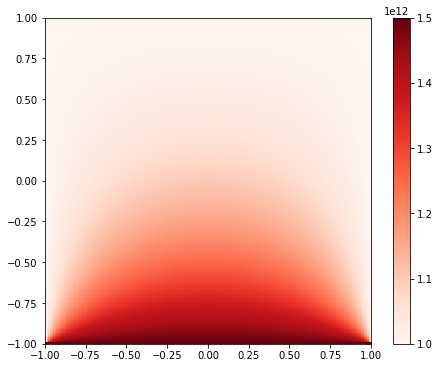

In [24]:
N = 201
M = 40001

print("CD_SPACE_RK4_TIME_ARRAY_SLICES_INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), INT_BIG_0, dtype=np.int64)

u[0, :] = INT_BIG_5

i = 0

with Timer() as t:
    
    while u[(N - 1) // 2, (N - 1) // 2] < INT_BIG_1:
        u = rk4_func(N, M, u)
        i = i + 1

print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(u)

### CD_SPACE_FE_TIME_OPENCL_INT64

In [30]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void kernel_cd_fe
    (
        const int n, \
        const int m, \
        __global long * restrict u, \
        __global long * restrict v, \
        __global long * restrict temperature
    )
{
    int r = get_global_id(0);
    int c = get_global_id(1);

    if (r == 0 || r == n - 1 || c == 0 || c == n - 1) {
        return;
    }

    v[n * r + c] = u[n * r + c] + (u[n * (r - 1) + c] + u[n * (r + 1) + c] + u[n * r + (c - 1)] + u[n * r + (c + 1)] - 4 * u[n * r + c]) * \
                    (n - 1) * (n - 1) / (4 * (m - 1));   

    // Export the temperature of the centre of the plate.
    
    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = v[n * r + c];
    }

    // Get ready for the next step by copying v to u.

    u[n * r + c] = v[n * r + c];
}

"""


# Define the class.

class CD_FE:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self.n = n
        self.m = m
                
        # Create a GPU specific context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers u and v as READ_WRITE because we may read the result from u or v.
 
        self.u = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.v = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
                        
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self.temperature = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize)

        # Build the kernel.
        
        self.kernel = cl.Program(self.ctx, kernel_string).build().kernel_cd_fe


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self.queue, self.u, u)


    def copy_v_to_device(self, v):
        cl.enqueue_copy(self.queue, self.v, v)


    def copy_v_from_device(self):
        v = np.zeros((self.n, self.n), dtype=np.int64)
        cl.enqueue_copy(self.queue, v, self.v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.int64)
        cl.enqueue_copy(self.queue, temperature, self.temperature)            
        return temperature[0]

           
    def step(self):
        """
        This method...
        """     
        self.kernel(self.queue, (self.n, self.n), None,
            np.int32(self.n),
            np.int32(self.m),
            self.u,
            self.v,
            self.temperature)

CD_SPACE_FE_TIME_OPENCL_INT64
N: 501
M: 500001
C: 0.125
T: 0.4240080000000000
Total time: 405.8607587814331


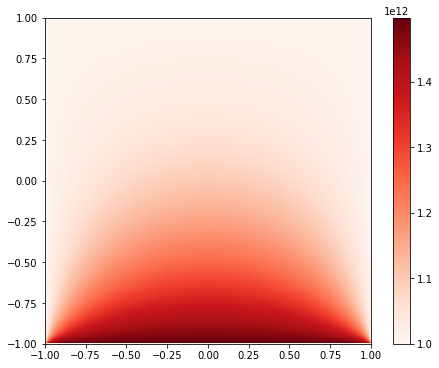

In [31]:
N = 501
M = 500001

print("CD_SPACE_FE_TIME_OPENCL_INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), INT_BIG_0, dtype=np.int64)
v = np.full((N, N), INT_BIG_0, dtype=np.int64)

u[0, :] = INT_BIG_5

cd_fe = CD_FE(N, M)

cd_fe.copy_u_to_device(u)
cd_fe.copy_v_to_device(v)

i = 0

with Timer() as t:

    while True:
        cd_fe.step()
        i = i + 1
        temperature = cd_fe.copy_temperature_from_device()
        if not temperature < INT_BIG_1:
            v = cd_fe.copy_v_from_device()
            break
        
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(v)

### CD_SPACE_RK4_TIME_OPENCL_INT64

In [27]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void kernel_cd_rk4
    (
        const int n, \
        const int m, \
        __global long * restrict u, \
        __global long * restrict v, \
        __global long * restrict k1, \
        __global long * restrict k2, \
        __global long * restrict k3, \
        __global long * restrict k4, \
        __global long * restrict temperature
    )
{
    int r = get_global_id(0);
    int c = get_global_id(1);

    if (r > 0 && r < n - 1 && c > 0 && c < n - 1) {

        k1[n * r + c] = ( \
                    u[n * (r - 1) + c] + \
                    u[n * (r + 1) + c] + \
                    u[n * r + (c - 1)] + \
                    u[n * r + (c + 1)] - 4 * u[n * r + c]) * \
                    (n - 1) * (n - 1) / (4 * (m - 1));   

        k2[n * r + c] = ( \
                    u[n * (r - 1) + c] + k1[n * (r - 1) + c] / 2 + \
                    u[n * (r + 1) + c] + k1[n * (r + 1) + c] / 2 + \
                    u[n * r + (c - 1)] + k1[n * r + (c - 1)] / 2 + \
                    u[n * r + (c + 1)] + k1[n * r + (c + 1)] / 2 - 4 * (u[n * r + c] + k1[n * r + c] / 2)) * \
                    (n - 1) * (n - 1) / (4 * (m - 1));

        k3[n * r + c] = ( \
                    u[n * (r - 1) + c] + k2[n * (r - 1) + c] / 2 + \
                    u[n * (r + 1) + c] + k2[n * (r + 1) + c] / 2 + \
                    u[n * r + (c - 1)] + k2[n * r + (c - 1)] / 2 + \
                    u[n * r + (c + 1)] + k2[n * r + (c + 1)] / 2 - 4 * (u[n * r + c] + k2[n * r + c] / 2)) * \
                    (n - 1) * (n - 1) / (4 * (m - 1));    

        k4[n * r + c] = ( \
                    u[n * (r - 1) + c] + k3[n * (r - 1) + c] + \
                    u[n * (r + 1) + c] + k3[n * (r + 1) + c] + \
                    u[n * r + (c - 1)] + k3[n * r + (c - 1)] + \
                    u[n * r + (c + 1)] + k3[n * r + (c + 1)] - 4 * (u[n * r + c] + k3[n * r + c])) * \
                    (n - 1) * (n - 1) / (4 * (m - 1));            
    }
    
    // Assemble bits...

    v[n * r + c] = u[n * r + c] + (k1[n * r + c] + 2 * k2[n * r + c] + 2 * k3[n * r + c] + k4[n * r + c]) / 6;

    // Export the temperature of the centre of the plate.
    
    if (r == (n - 1) / 2 && c == (n - 1) / 2) {
        temperature[0] = v[n * r + c];
    }

    // Get ready for the next step by copying v to u.

    u[n * r + c] = v[n * r + c];
}

"""


# Define the class.

class CD_RK4:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self.n = n
        self.m = m
                
        # Create a GPU specific context and command queue.
        
        self.ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self.queue = cl.CommandQueue(self.ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 
        # Create input and output buffers u and v as READ_WRITE because we may read the result from u or v.
 
        self.u = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.v = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        
        # Create buffers to hold the intermediate Runge-Kutta values.
        
        self.k1 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k2 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k3 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self.k4 = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
                
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self.temperature = cl.Buffer(self.ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize)

        # Build the kernel.
        
        self.kernel = cl.Program(self.ctx, kernel_string).build().kernel_cd_rk4


    def copy_u_to_device(self, u):
        cl.enqueue_copy(self.queue, self.u, u)


    def copy_v_to_device(self, v):
        cl.enqueue_copy(self.queue, self.v, v)


    def copy_k1_to_device(self, k1):
        cl.enqueue_copy(self.queue, self.k1, k1)


    def copy_k2_to_device(self, k2):
        cl.enqueue_copy(self.queue, self.k2, k2)


    def copy_k3_to_device(self, k3):
        cl.enqueue_copy(self.queue, self.k3, k3)


    def copy_k4_to_device(self, k4):
        cl.enqueue_copy(self.queue, self.k4, k4)


    def copy_v_from_device(self):
        v = np.zeros((self.n, self.n), dtype=np.int64)
        cl.enqueue_copy(self.queue, v, self.v)            
        return v


    def copy_temperature_from_device(self):
        temperature = np.zeros((1), dtype=np.int64)
        cl.enqueue_copy(self.queue, temperature, self.temperature)            
        return temperature[0]

           
    def step(self):
        """
        This method...
        """     
        self.kernel(self.queue, (self.n, self.n), None,
            np.int32(self.n),
            np.int32(self.m),
            self.u,
            self.v,
            self.k1,
            self.k2,
            self.k3,
            self.k4,
            self.temperature)

CD_SPACE_RK4_TIME_OPENCL_INT64
N: 201
M: 40001
C: 0.25
T: 0.4239500000000000
Total time: 25.000579833984375


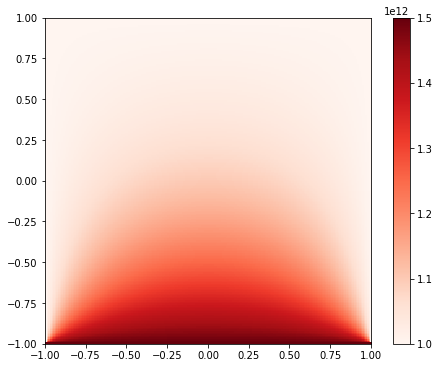

In [28]:
N = 201
M = 40001

print("CD_SPACE_RK4_TIME_OPENCL_INT64")
print("N: {}".format(N))
print("M: {}".format(M))
print("C: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

u = np.full((N, N), INT_BIG_0, dtype=np.int64)

u[0, :] = INT_BIG_5

v = np.zeros((N, N), dtype=u.dtype)

k1 = np.zeros((N, N), dtype=u.dtype)
k2 = np.zeros((N, N), dtype=u.dtype)
k3 = np.zeros((N, N), dtype=u.dtype)
k4 = np.zeros((N, N), dtype=u.dtype)

cd_rk4 = CD_RK4(N, M)

cd_rk4.copy_u_to_device(u)
cd_rk4.copy_v_to_device(v)

cd_rk4.copy_k1_to_device(k1)
cd_rk4.copy_k2_to_device(k2)
cd_rk4.copy_k3_to_device(k3)
cd_rk4.copy_k4_to_device(k4)

i = 0

with Timer() as t:

    while True:
        cd_rk4.step()
        i = i + 1
        temperature = cd_rk4.copy_temperature_from_device()
        if not temperature < INT_BIG_1:
            v = cd_rk4.copy_v_from_device()
            break
        
print("T: {:.16f}".format(i / (M - 1)))
print("Total time: {0}".format(t.interval))

plot(v)